## Cassava Leaf Disease Classification

In [2]:
# import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Flatten, Dense, GlobalAveragePooling2D, BatchNormalization, Activation, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_input_
from tensorflow.keras.applications import EfficientNetB3 
%matplotlib inline

In [3]:
# Set seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Data dir
train_dir = 'train_images/'
test_dir = 'test_images/'
# Load meta data
train_df = pd.read_csv('train.csv')
label_js = pd.read_json('label_num_to_disease_map.json', 
                         orient='index')

train_df.head(3)

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1


3    13158
4     2577
2     2386
1     2189
0     1087
Name: label, dtype: int64


Text(0, 0.5, 'Counts/Frequency')

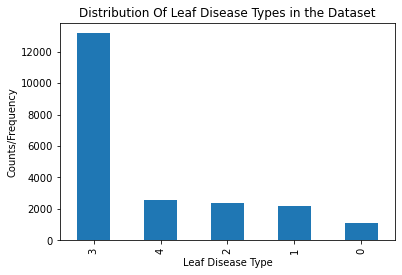

In [4]:
# analyse target variable distribution
print(train_df['label'].value_counts())
train_df['label'].value_counts().plot(kind='bar')
plt.title("Distribution Of Leaf Disease Types in the Dataset")
plt.xlabel("Leaf Disease Type")
plt.ylabel("Counts/Frequency")

It can be seen that class **3** has a significantly higher number of images in the dataset compared to other leaf disease types; with class **0** having the least number of images.

In [5]:
# Link train images to their respective image ids
train_df['image'] = train_dir + train_df['image_id']
train_df.head(3)

,image_id,label,image
0,1000015157.jpg,0,train_images/1000015157.jpg
1,1000201771.jpg,3,train_images/1000201771.jpg
2,100042118.jpg,1,train_images/100042118.jpg


### Visualizing Cassava Images
Display a sample of cassava leaf images.

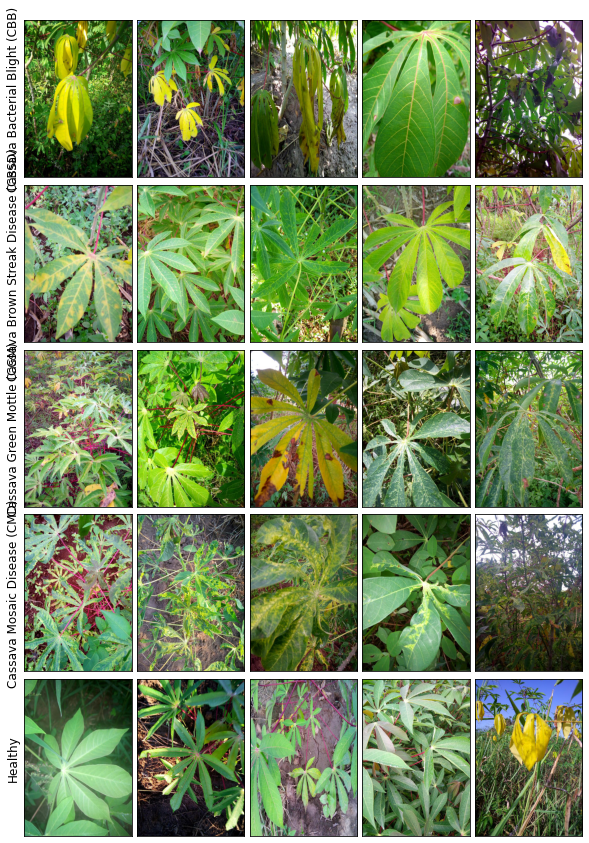

In [6]:
def visualize_images(num:int):
    """Display a sample of num^2 cassava leaf images per disease class."""
    fig, axes = plt.subplots(nrows=num, ncols=num, figsize=(10,15))
    for row in np.arange(num):
        for col in np.arange(num):        
            cur_img_name = train_df[train_df.label==row].image.sample().values[0]
            cur_img = image.load_img(cur_img_name)
            cur_img = image.img_to_array(cur_img)
            axes[row, col].imshow(cur_img/255., aspect='auto')  
            axes[row, col].tick_params(axis='both', which='both', 
                                       bottom=False, top=False, 
                                       labelbottom=False, right=False, 
                                       left=False, labelleft=False)
    for ax, label in zip(axes[:,0], label_js[0]):
        ax.set_ylabel(label, rotation=90, size='large')

    plt.subplots_adjust(wspace=.05, hspace=.05)
    plt.show()

visualize_images(5)

### Data wrangling
* Split dataset into train and test images.
* Encode target variable (type of leaf disease)

In [7]:
# Split the data into train and test images
X_train, X_val, y_train, y_val = train_test_split(train_df['image'],
                                                  train_df['label'],
                                                  test_size=0.15,
                                                  random_state=42,
                                                  shuffle=True
                                                 )
# Define and fit the label encoder
encoder = LabelBinarizer()
encoder.fit(train_df['label'])

# Encoder the labels
y_train_lb = encoder.transform(y_train)
y_val_lb = encoder.transform(y_val)

# Parse train and test images into pandas dataframes
X_train_df = pd.DataFrame(X_train).reset_index().drop(labels='index', axis=1)
y_train_df = pd.DataFrame(y_train_lb).add_prefix('label_')
X_val_df = pd.DataFrame(X_val).reset_index().drop(labels='index', axis=1)
y_val_df = pd.DataFrame(y_val_lb).add_prefix('label_')

# Concatenate train and test images with corresponding labels
train = pd.concat([X_train_df, y_train_df], axis=1)
validation = pd.concat([X_val_df, y_val_df], axis=1)


### Create Model Image Generators
Define image generators to feed data into the model for training

In [8]:
def create_generators(input_, image_size):
    """
    Creates and returns train and test image data generators.
    """
    train_datagen = ImageDataGenerator(preprocessing_function=input_)
    val_datagen = ImageDataGenerator(preprocessing_function=input_)

    train_generator = train_datagen.flow_from_dataframe(
        train,
        x_col='image',
        y_col=[f'label_{x}' for x in np.arange(5)],
        target_size=image_size,
        batch_size=32,
        shuffle=True,
        class_mode='raw'
    )

    validation_generator = val_datagen.flow_from_dataframe(
        validation,
        x_col='image',
        y_col=[f'label_{x}' for x in np.arange(5)],
        target_size=image_size,
        shuffle=False,
        batch_size=32,
        class_mode='raw'
    )
    return train_generator, validation_generator


#Invoke the function to return the generators
train_generator, validation_generator = create_generators(preprocess_input_,
                                                          (224,224)
                                                          )

Found 18187 validated image filenames.
Found 3210 validated image filenames.


### Building the Model
* Define a ResNet50 to serve as a backbone model for leaf disease classification model architecture
* Add some additional layers on top of the ResNet50 model and a final classification layer

In [9]:
# Load the resnet50 model
backbone_model = tf.keras.applications.resnet50.ResNet50(input_shape=(224,224, 3),
                                                          include_top=False, # exclude the head
                                                          weights='imagenet'
                                                         )

# Load Efficientnetb3 model
# effnet_weights_dir = "../input/base-model-weights-rn50-enb3/efficientnetb3_notop.h5" # pretrained weights directory
# efficient_net_backbone = EfficientNetB3(weights=None,
#                                         include_top=False,
#                                         input_shape=(300, 300, 3),
#                                         drop_connect_rate=0.4
#                                         )
# efficient_net_backbone.load_weights(effnet_weights_dir)  # load pretrained weights into the model 
# efficient_net_backbone.trainable = True   # This ensure the model can be trained again on our new dataset

Adding layers for classification

In [10]:
def build_model(MODEL):
    """Build leaf disease classification model."""
    dropout_rate = 0.3
    resnet_model = Sequential()
    resnet_model.add(MODEL) # Add the pretrained model the backbone

    resnet_model.add(GlobalAveragePooling2D())
    resnet_model.add(Dense(128))
    resnet_model.add(BatchNormalization())
    resnet_model.add(Activation('relu'))
    resnet_model.add(Dense(32))
    resnet_model.add(BatchNormalization())
    resnet_model.add(Activation('relu'))
    resnet_model.add(Dropout(dropout_rate))

    resnet_model.add(Dense(5, activation='softmax')) # Classification layer    
    resnet_model.compile(optimizer='adam', 
                     loss=CategoricalCrossentropy(label_smoothing=0.05),
                     metrics=['categorical_accuracy']
                    )
    resnet_model.summary()
    return resnet_model

resnet_model = build_model(backbone_model)
# effnet_model = build_model(efficient_net_backbone)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
activation (Activation)      (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                1

In [11]:
tf.keras.utils.plot_model(resnet_model, to_file='model.png')

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [12]:
# Model hyperparameters
EPOCHS = 15
BATCH_SIZE = 32

# define model callback functions
weight_path_save = './resnet_model.h5'#'./effnet_model.h5'
last_weight_path = './last_model_weight.h5'

# checkpoint best model
checkpoint = tf.keras.callbacks.ModelCheckpoint(weight_path_save,
                                                monitor='val_loss', 
                                                verbose=1, 
                                                save_best_only=True, 
                                                mode='min', 
                                                save_weights_only=False
                                               )

# checkpoint model weights at every lowest val_loss epoch
last_checkpoint = tf.keras.callbacks.ModelCheckpoint(last_weight_path, 
                                                     monitor='val_loss', 
                                                     verbose=1, 
                                                     save_best_only=False, 
                                                     mode='min', 
                                                     save_weights_only=False
                                                    )

# early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                  mode='min', 
                                                  patience=10
                                                 )
# learning rate decay
lr_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=2, verbose=1, mode='auto', epsilon=0.0001, cooldown=5, min_lr=0.00001)
callbacks_ = [checkpoint, last_checkpoint, early_stopping, lr_reduction]


def train_model(MODEL):
    """Train an input MODEL type on the leaf dataset."""
    history = MODEL.fit_generator(generator=train_generator,
                                  validation_data=validation_generator,
                                  steps_per_epoch=len(train)//BATCH_SIZE,
                                  epochs=EPOCHS,
                                  callbacks=callbacks_
                                  )
    return history, MODEL

#history, trained_model = train_model(effnet_model)
history, resnet_model = train_model(resnet_model)

C:\Users\Jay\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
568/568 [==============================] - 3419s 6s/step - loss: 1.3095 - categorical_accuracy: 0.5872 - val_loss: 1.3776 - val_categorical_accuracy: 0.6221

Epoch 00001: val_loss improved from inf to 1.37758, saving model to .\resnet_model.h5

Epoch 00001: saving model to .\last_model_weight.h5
Epoch 2/15
568/568 [==============================] - 3373s 6s/step - loss: 0.9820 - categorical_accuracy: 0.6588 - val_loss: 1.2311 - val_categorical_accuracy: 0.6804

Epoch 00002: val_loss improved from 1.37758 to 1.23105, saving model to .\resnet_model.h5

Epoch 00002: saving model to .\last_model_weight.h5
Epoch 3/15
568/568 [==============================] - 3372s 6s/step - loss: 0.8884 - categorical_accuracy: 0.7015 - val_loss: 1.4830 - val_categorical_accuracy: 0.4371

Epoch 00003: val_loss did not improve from 1.23105

Epoch 00003: saving model to .\last_model_weight.h5
Epoch 4/15
568/568 [==============================] - 3363s 6s/step - loss: 0.8465 - categorical_accuracy: 

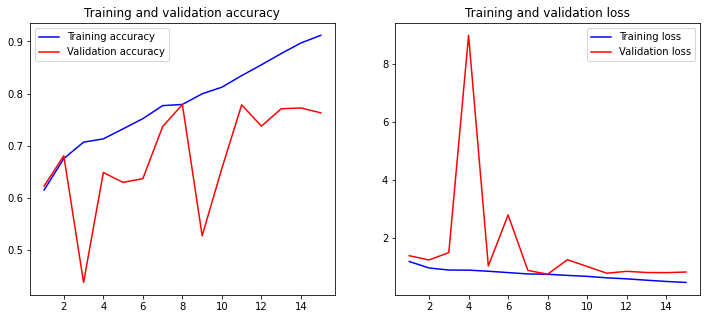

In [13]:
# Loss curves
def plot_history(history):
    accuracy = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(accuracy) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, accuracy, 'b', label='Training accuracy')
    plt.plot(x, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.savefig('score.png')
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

plot_history(history)

In [14]:
# Average accuracy score
mean_accuracy = np.mean(history.history['val_categorical_accuracy'])
print(f'Average accuracy {mean_accuracy}')

Average accuracy 0.6782346864541372


In [15]:
# Load trained weights into the model
resnet_model.load_weights("./resnet_model.h5")
#effnet_model.load_weights("./effnet_model.h5")

# Evaluate test performance using other classification metrics
test_predictions = resnet_model.predict(validation_generator,  verbose=True)
#test_predictions = effnet_model.predict(validation_generator,  verbose=True)
test_predictions = np.argmax(test_predictions, axis=-1)
test_labels = encoder.inverse_transform(validation_generator.labels) # convert labels back to their original format for classification evaluation

101/101 [==============================] - 99s 975ms/step


In [16]:
# Generate the classification report
print(classification_report(test_labels, test_predictions))

              precision    recall  f1-score   support

           0       0.43      0.47      0.45       147
           1       0.71      0.47      0.57       330
           2       0.81      0.33      0.47       356
           3       0.86      0.96      0.91      1996
           4       0.52      0.62      0.57       381

    accuracy                           0.78      3210
   macro avg       0.67      0.57      0.59      3210
weighted avg       0.78      0.78      0.76      3210



In [17]:
## Reference for the label encoding and image visualization techniques
# - https://www.kaggle.com/dmikar/keras-resnet50-ra-test
# - https://www.kaggle.com/harveenchadha/efficientnetb3-keras-tf2-baseline-training